In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Times New Roman"]})

In [52]:
toi_df = pd.read_csv("output_data/TOI_2025.08.02_05.03.17_final_predicted.csv")
toi_df

,toi,tid,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_eqt,pl_insol,st_teff,st_logg,st_rad,ra,dec,tfopwg_disp,fe_h,gaia_source_id,Prediction
0,1007.01,TIC 65212867,6.998921,3.953000,2840.000000,14.775200,1282.000000,448.744000,6596.0,3.71000,2.700000,112.752393,-4.463359,PC,0.154000,Gaia DR3 3060208664203492992,0
1,101.01,TIC 231663901,1.430370,1.616599,18960.712294,13.187450,1525.904809,1281.240825,5600.0,4.48851,0.890774,318.737012,-55.871863,KP,-0.261609,Gaia DR3 6462994429708755072,0
2,1011.01,TIC 114018671,2.470498,2.191000,250.000000,1.446560,1364.000000,575.597000,5413.7,4.46000,0.940000,113.984761,-32.841999,PC,-0.110000,Gaia DR3 5592015297342611968,1
3,1016.01,TIC 175310067,12.688942,7.920100,3232.852788,14.060834,1158.131037,425.159418,7601.0,4.31000,1.536410,116.110771,-36.098285,FP,0.223936,Gaia DR3 5587573167284647296,1
4,1018.01,TIC 291555748,4.959120,2.509000,7440.000000,22.912300,1419.000000,673.550000,5889.0,3.86000,2.000000,111.716019,-50.266567,FP,-0.118993,Gaia DR3 5505717481529404416,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5177,981.01,TIC 127476180,1.605559,2.253000,1168.000000,4.703080,2124.000000,3384.430000,6711.0,4.25000,1.480000,117.113226,-28.204828,FP,0.292080,Gaia DR3 5601388187294617856,0
5178,987.01,TIC 52548453,5.214676,4.983063,3754.150648,14.447677,1607.354148,1037.070000,6080.0,3.78000,2.270000,100.925700,-30.491967,FP,0.080000,Gaia DR3 5584423341345392896,1
5179,988.01,TIC 113553629,4.304380,3.037000,672.002000,13.756400,1319.000000,503.880000,6056.9,4.17000,4.820000,113.424039,-30.996054,FP,0.288790,Gaia DR3 5593167070135870080,1
5180,997.01,TIC 341729521,8.413486,3.556833,17479.605331,20.510696,857.731431,127.916421,5786.0,4.52000,0.926261,121.319521,-59.579798,FP,-0.480000,Gaia DR3 5291265022797336448,0


In [53]:
toi_pc = toi_df[(toi_df['Prediction'] == 1) & ((toi_df['tfopwg_disp'] != 'FP') & (toi_df['tfopwg_disp'] != 'FA'))].copy()
toi_pc['tfopwg_disp'].value_counts()

tfopwg_disp
PC     2341
CP      523
KP      356
APC      75
Name: count, dtype: int64

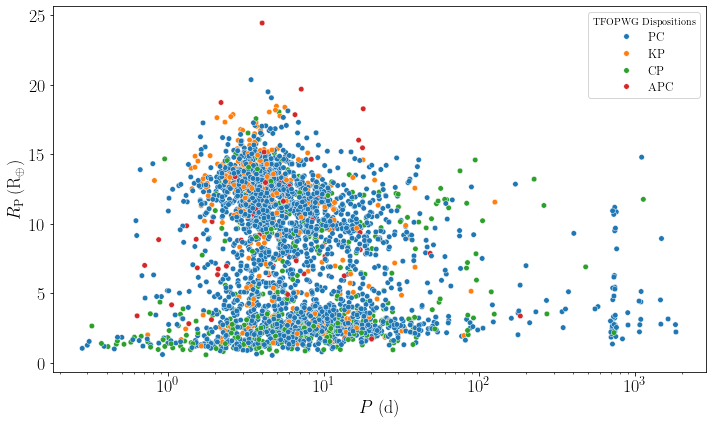

In [75]:
# Radius vs. Orbital Period for confirmed planets and planet candidates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=toi_pc, x='pl_orbper', y='pl_rade', hue='tfopwg_disp', s=30)
plt.xscale('log')
plt.xlabel(r'$P$ (d)', fontsize=18)
plt.ylabel(r'$R_{\mathrm P}\,(\mathrm{R_\oplus})$', fontsize=18)
plt.legend(title='TFOPWG Dispositions', loc='upper right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.savefig('figures/toi_radius_vs_period.pdf')
plt.show()

In [ ]:
from astroquery.gaia import Gaia
# obtain Gaia DR3 mass, luminosity, teff

gaia_id = toi_pc['gaia_source_id'].dropna().drop_duplicates()

gaia_id = gaia_id.str.replace('Gaia DR3 ', '', regex=False).values

parameter_query = ("""select g.source_id, r_med_geo, r_lo_geo, r_hi_geo, g.phot_g_mean_mag
                    From gaiadr3.gaia_source as g
                    JOIN external.gaiaedr3_distance as dist on g.source_id = dist.source_id
                    where
                    g.source_id in ("""+(len(gaia_id)-1)*"{},"+"{})").format(*gaia_id)

# Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1

job = Gaia.launch_job_async(parameter_query)
r = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [64]:
r['source_id'] = 'Gaia DR3 ' + r['source_id'].astype(str)
toi_pc_dist_gmag = pd.merge(toi_pc, r[['source_id', 'r_med_geo', 'phot_g_mean_mag']], left_on='gaia_source_id', right_on='source_id', how='left').drop(columns=['source_id'])

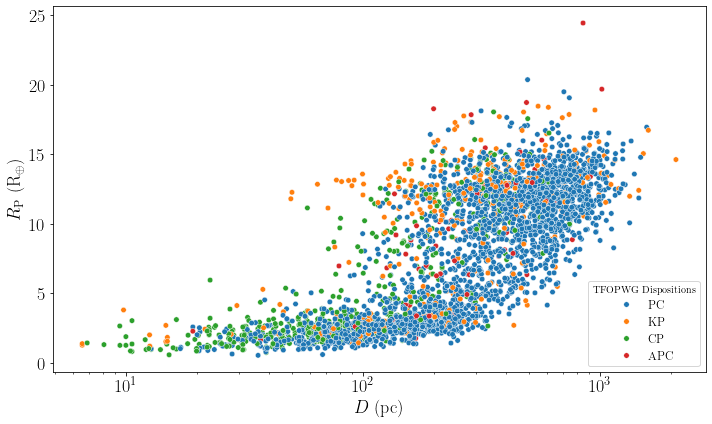

In [76]:
# Radius vs. distance for confirmed planets and planet candidates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=toi_pc_dist_gmag, x='r_med_geo', y='pl_rade', hue='tfopwg_disp', s=30)
plt.xscale('log')
plt.xlabel(r'$D$ (pc)', fontsize=18)
plt.ylabel(r'$R_{\mathrm P}~(\mathrm{R_\oplus})$', fontsize=18)
plt.legend(title='TFOPWG Dispositions', loc='lower right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.savefig('figures/toi_radius_vs_distance.pdf')
plt.show()

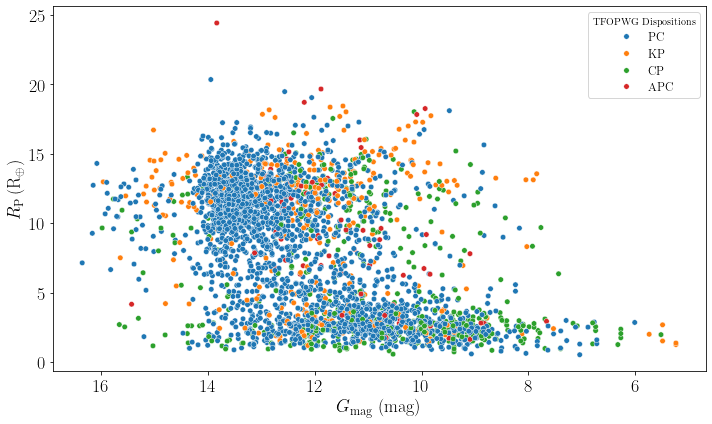

In [77]:
# Radius vs. Gmag
plt.figure(figsize=(10, 6))
sns.scatterplot(data=toi_pc_dist_gmag, x='phot_g_mean_mag', y='pl_rade', hue='tfopwg_disp', s=30)
plt.gca().invert_xaxis()
plt.xlabel(r'$G_\mathrm{mag}$ (mag)', fontsize=18)
plt.ylabel(r'$R_{\mathrm P}\,(\mathrm{R_\oplus})$', fontsize=18)
plt.legend(title='TFOPWG Dispositions', loc='upper right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.savefig('figures/toi_radius_vs_gmag.pdf')
plt.show()

In [9]:
koi_df = pd.read_csv("output_data/KOI_2025.07.31_cleaned.csv")
koi_df

,Unnamed: 0,koi_period,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,koi_smet,ExoplanetCandidate
0,0,9.488036,2.95750,615.8,2.26,793.0,93.59,5455.0,4.467,0.927,0.14,1
1,1,54.418383,4.50700,874.8,2.83,443.0,9.11,5455.0,4.467,0.927,0.14,1
2,2,19.899140,1.78220,10829.0,14.60,638.0,39.30,5853.0,4.544,0.868,-0.18,1
3,3,1.736952,2.40641,8079.2,33.46,1395.0,891.96,5805.0,4.564,0.791,-0.52,0
4,4,2.525592,1.65450,603.3,2.75,1406.0,926.16,6031.0,4.438,1.046,0.07,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9173,9559,0.527699,3.22210,1579.2,29.35,2088.0,4500.53,5638.0,4.529,0.903,0.14,0
9174,9560,1.739849,3.11400,48.5,0.72,1608.0,1585.81,6119.0,4.444,1.031,-0.04,1
9175,9561,0.681402,0.86500,103.6,1.07,2218.0,5713.41,6173.0,4.447,1.041,-0.04,0
9176,9562,333.486169,3.19900,639.1,19.30,557.0,22.68,4989.0,2.992,7.824,0.07,1


In [10]:
koi_pc = koi_df[koi_df['ExoplanetCandidate']==1].copy()
koi_pc

,Unnamed: 0,koi_period,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,koi_smet,ExoplanetCandidate
0,0,9.488036,2.9575,615.8,2.26,793.0,93.59,5455.0,4.467,0.927,0.14,1
1,1,54.418383,4.5070,874.8,2.83,443.0,9.11,5455.0,4.467,0.927,0.14,1
2,2,19.899140,1.7822,10829.0,14.60,638.0,39.30,5853.0,4.544,0.868,-0.18,1
4,4,2.525592,1.6545,603.3,2.75,1406.0,926.16,6031.0,4.438,1.046,0.07,1
5,5,11.094321,4.5945,1517.5,3.90,835.0,114.81,6046.0,4.486,0.972,-0.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9152,9538,7.268182,4.9850,46.7,1.66,1444.0,1027.95,6297.0,3.890,2.219,0.00,1
9156,9542,376.379890,13.9900,1140.0,3.26,265.0,1.16,6231.0,4.488,0.955,-0.32,1
9166,9552,367.947848,4.2490,1301.0,3.72,228.0,0.64,5570.0,4.561,0.855,0.07,1
9174,9560,1.739849,3.1140,48.5,0.72,1608.0,1585.81,6119.0,4.444,1.031,-0.04,1


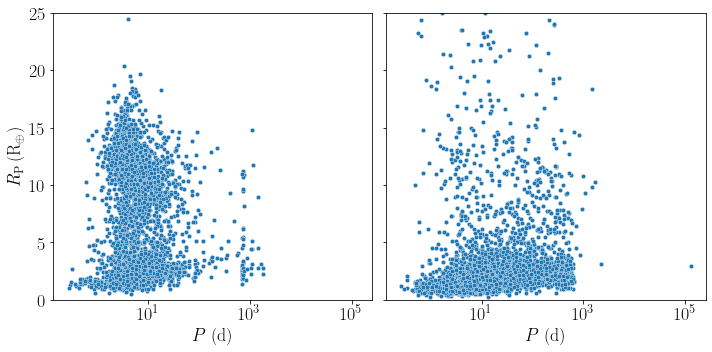

In [97]:
# side-by-side comparison of TOI and KOI planet candidates, radius vs period, share the same axis limits
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(data=toi_pc, x='pl_orbper', y='pl_rade', s=20, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_ylim([0, 25])
axes[0].set_xlabel(r'$P$ (d)', fontsize=18)
axes[0].set_ylabel(r'$R_{\mathrm P}\,(\mathrm{R_\oplus})$', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)
sns.scatterplot(data=koi_pc, x='koi_period', y='koi_prad', s=20, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_ylim([0, 25])
axes[1].set_xlabel(r'$P$ (d)', fontsize=18)
axes[1].set_ylabel('')
axes[1].tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.savefig('figures/toi_koi_radius_vs_period_comparison.pdf')
plt.show()

In [95]:
# number of hot Jupiters (P<12d, R>10Re) in TOI and KOI
toi_hot_jupiters = toi_pc[(toi_pc['pl_orbper'] < 12) & (toi_pc['pl_rade'] > 10)]
koi_hot_jupiters = koi_pc[(koi_pc['koi_period'] < 12) & (koi_pc['koi_prad'] > 10)]
print(f"Number of hot Jupiters in TOI: {len(toi_hot_jupiters)}, {len(toi_hot_jupiters)/len(toi_pc)*100:.2f}% of TOI PC")
print(f"Number of hot Jupiters in KOI: {len(koi_hot_jupiters)}, {len(koi_hot_jupiters)/len(koi_pc)*100:.2f}% of KOI PC")

Number of hot Jupiters in TOI: 1227, 37.24% of TOI PC
Number of hot Jupiters in KOI: 119, 2.58% of KOI PC


# spectral

In [102]:
def determine_spectral_type(st_teff):
    if st_teff > 33000:
        return 'O'
    elif 10000 <= st_teff <= 33000:
        return 'B'
    elif 7500 <= st_teff < 10000:
        return 'A'
    elif 6000 <= st_teff < 7500:
        return 'F'
    elif 5200 <= st_teff < 6000:
        return 'G'
    elif 3700 <= st_teff < 5200:
        return 'K'
    else:
        return 'M'

In [104]:
toi_pc['Spectral_Type'] = toi_pc['st_teff'].apply(determine_spectral_type)
koi_pc['Spectral_Type'] = koi_pc['koi_steff'].apply(determine_spectral_type)

In [114]:
toi_pc['source'] = 'TOI'
koi_pc['source'] = 'KOI'

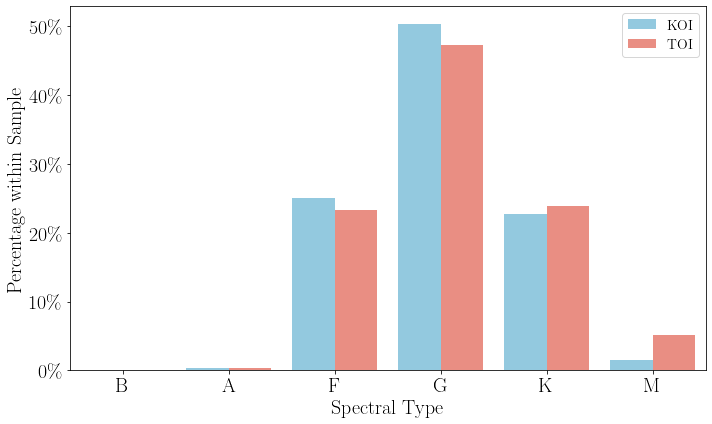

In [150]:
from matplotlib.ticker import FuncFormatter

combined_df = pd.concat([toi_pc, koi_pc])

# Optional: enforce a sensible spectral-type order (customize if needed)
preferred_order = ['O','B','A','F','G','K','M']
# keep only types present in your df (or use sorted(df['Spectral_Type'].unique()))
order = [s for s in preferred_order if s in combined_df['Spectral_Type'].unique()]
if not order:
    order = sorted(combined_df['Spectral_Type'].unique())

# Compute counts and percent within each Source
counts = combined_df.groupby(['source', 'Spectral_Type']).size().reset_index(name='count')
counts['percent'] = counts.groupby('source')['count'].transform(lambda x: 1.0 * x / x.sum() * 100)

# Plot percentages with side-by-side bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=counts,
    x='Spectral_Type',
    y='percent',
    hue='source',
    order=order,
    errorbar=None,
    palette={'TOI': 'salmon', 'KOI': 'skyblue'}
)

# Format axes and labels
ax.set_xlabel('Spectral Type', fontsize=20)
ax.set_ylabel('Percentage within Sample', fontsize=20)

# Add % sign to y-tick labels
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}\%'))

plt.legend(title='', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig('figures/toi_koi_spectral_type_comparison_percent.pdf')
plt.show()

In [152]:
koi_pc['Spectral_Type'].value_counts()

Spectral_Type
G    2325
F    1156
K    1046
M      72
A      16
B       1
Name: count, dtype: int64

In [200]:
koi_df_full = pd.read_csv('input_data/KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')
koi_df_full

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-0.176,-0.18,0.30,-0.30,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-0.168,-0.52,0.30,-0.30,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-0.210,0.07,0.25,-0.30,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,-0.196,0.14,0.20,-0.30,0.903,0.237,-0.079,297.18875,47.093819,14.082
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,-0.224,-0.04,0.25,-0.30,1.031,0.341,-0.114,286.50937,47.163219,14.757
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,...,-0.224,-0.04,0.25,-0.35,1.041,0.341,-0.114,294.16489,47.176281,15.385
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,...,-0.027,0.07,0.10,-0.25,7.824,0.223,-1.896,296.76288,47.145142,10.998


In [201]:
koi_df_full['ExoplanetCandidate'] = koi_df_full['koi_disposition'].apply(lambda x: 1 if x == 'CANDIDATE' or x == 'CONFIRMED' else 0)
# Load and preprocess data
short_cols = ['kepid', 'kepoi_name', 'koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
              'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

koi_df_full = koi_df_full[short_cols].dropna()

In [202]:
koi_pc_full = koi_df_full[koi_df_full['ExoplanetCandidate']==1].copy()
koi_pc_full

,kepid,kepoi_name,koi_period,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,koi_smet,ExoplanetCandidate
0,10797460,K00752.01,9.488036,2.9575,615.8,2.26,793.0,93.59,5455.0,4.467,0.927,0.14,1
1,10797460,K00752.02,54.418383,4.5070,874.8,2.83,443.0,9.11,5455.0,4.467,0.927,0.14,1
2,10811496,K00753.01,19.899140,1.7822,10829.0,14.60,638.0,39.30,5853.0,4.544,0.868,-0.18,1
4,10854555,K00755.01,2.525592,1.6545,603.3,2.75,1406.0,926.16,6031.0,4.438,1.046,0.07,1
5,10872983,K00756.01,11.094321,4.5945,1517.5,3.90,835.0,114.81,6046.0,4.486,0.972,-0.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9538,9938836,K07978.01,7.268182,4.9850,46.7,1.66,1444.0,1027.95,6297.0,3.890,2.219,0.00,1
9542,10011213,K07982.01,376.379890,13.9900,1140.0,3.26,265.0,1.16,6231.0,4.488,0.955,-0.32,1
9552,10028127,K08193.01,367.947848,4.2490,1301.0,3.72,228.0,0.64,5570.0,4.561,0.855,0.07,1
9560,10128825,K07986.01,1.739849,3.1140,48.5,0.72,1608.0,1585.81,6119.0,4.444,1.031,-0.04,1


In [203]:
koi_pc_full['Spectral_Type'] = koi_pc_full['koi_steff'].apply(determine_spectral_type)

In [204]:
from astroquery.simbad import Simbad

Simbad.TIMEOUT = 1200
Simbad.ROW_LIMIT = -1
Simbad.add_votable_fields('ids')

def fetch_gaia_source_id_with_target_identifiers(target_ids):
    """Query directly Gaia DR3 source_id with tid

    Parameters:
    target_ids (array-like): star identifiers

    return:
    gaia_source_id (array-like): Gaia DR3 source_id

    """
    s = Simbad.query_objects(target_ids)
    gaia_source_id = np.full(len(target_ids), np.nan).astype(object)
    if s is None:
        print("No results found for the provided target identifiers.")
        return gaia_source_id
    
    for i in s:
        ids = i['ids'].split('|')
        index = i['object_number_id']-1
        for jd in ids:
            if 'Gaia DR3' in jd:
                gaia_source_id[index] = jd
    return gaia_source_id

In [205]:
# add prefix 'KIC' to each id of tid column
star_names = ['KIC ' + str(kid) for kid in koi_pc_full['kepid']]

print(f"Querying {len(star_names)} stars for Gaia DR3 source IDs...")
print("-" * 50)

# Fetch Gaia source IDs for the target identifiers
gaia_source_ids = fetch_gaia_source_id_with_target_identifiers(star_names)

koi_pc_full['gaia_source_id'] = gaia_source_ids
print(f"end= {len(koi_pc_full[koi_pc_full['gaia_source_id'].notna()])} stars with Gaia DR3 source IDs")

Querying 4616 stars for Gaia DR3 source IDs...
--------------------------------------------------
end= 4509 stars with Gaia DR3 source IDs


In [206]:
gaia_id = koi_pc_full['gaia_source_id'].dropna().drop_duplicates()

gaia_id = gaia_id.str.replace('Gaia DR3 ', '', regex=False).values

parameter_query = ("""select g.source_id, r_med_geo, r_lo_geo, r_hi_geo, g.phot_g_mean_mag
                    From gaiadr3.gaia_source as g
                    JOIN external.gaiaedr3_distance as dist on g.source_id = dist.source_id
                    where
                    g.source_id in ("""+(len(gaia_id)-1)*"{},"+"{})").format(*gaia_id)

# Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1

job = Gaia.launch_job_async(parameter_query)
r = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [207]:
r['source_id'] = 'Gaia DR3 ' + r['source_id'].astype(str)
koi_pc_full_dist_gmag = pd.merge(koi_pc_full, r[['source_id', 'r_med_geo', 'phot_g_mean_mag']], left_on='gaia_source_id', right_on='source_id', how='left').drop(columns=['source_id'])
koi_pc_full_dist_gmag

,kepid,kepoi_name,koi_period,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,koi_smet,ExoplanetCandidate,Spectral_Type,gaia_source_id,r_med_geo,phot_g_mean_mag
0,10797460,K00752.01,9.488036,2.9575,615.8,2.26,793.0,93.59,5455.0,4.467,0.927,0.14,1,G,Gaia DR3 2129273849959814656,1058.584839,15.308912
1,10797460,K00752.02,54.418383,4.5070,874.8,2.83,443.0,9.11,5455.0,4.467,0.927,0.14,1,G,Gaia DR3 2129273849959814656,1058.584839,15.308912
2,10811496,K00753.01,19.899140,1.7822,10829.0,14.60,638.0,39.30,5853.0,4.544,0.868,-0.18,1,G,Gaia DR3 2086623622121548800,1519.525635,15.403214
3,10854555,K00755.01,2.525592,1.6545,603.3,2.75,1406.0,926.16,6031.0,4.438,1.046,0.07,1,F,Gaia DR3 2130969262529165184,1230.401001,15.485445
4,10872983,K00756.01,11.094321,4.5945,1517.5,3.90,835.0,114.81,6046.0,4.486,0.972,-0.08,1,F,Gaia DR3 2086660283961964416,1534.525146,15.692461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,9938836,K07978.01,7.268182,4.9850,46.7,1.66,1444.0,1027.95,6297.0,3.890,2.219,0.00,1,F,Gaia DR3 2131336224533349760,1357.167725,13.875067
4612,10011213,K07982.01,376.379890,13.9900,1140.0,3.26,265.0,1.16,6231.0,4.488,0.955,-0.32,1,F,Gaia DR3 2129091193589772288,1461.248413,15.574965
4613,10028127,K08193.01,367.947848,4.2490,1301.0,3.72,228.0,0.64,5570.0,4.561,0.855,0.07,1,G,Gaia DR3 2086312971424259200,1191.065430,15.712454
4614,10128825,K07986.01,1.739849,3.1140,48.5,0.72,1608.0,1585.81,6119.0,4.444,1.031,-0.04,1,F,Gaia DR3 2130657069945260160,1391.636108,14.720476


In [208]:
(koi_pc_full_dist_gmag[koi_pc_full_dist_gmag['Spectral_Type']=='M']['phot_g_mean_mag']>=14).sum() / len(koi_pc_full_dist_gmag[koi_pc_full_dist_gmag['Spectral_Type']=='M'])

0.8194444444444444

In [209]:
toi_pc_dist_gmag['Spectral_Type'] = toi_pc_dist_gmag['st_teff'].apply(determine_spectral_type)
toi_pc_dist_gmag

,toi,tid,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_eqt,pl_insol,st_teff,st_logg,st_rad,ra,dec,tfopwg_disp,fe_h,gaia_source_id,Prediction,r_med_geo,phot_g_mean_mag,Spectral_Type
0,1011.01,TIC 114018671,2.470498,2.191000,250.000000,1.446560,1364.000000,575.597000,5413.7,4.46000,0.94000,113.984761,-32.841999,PC,-0.110000,Gaia DR3 5592015297342611968,1,52.345104,8.739241,G
1,1027.01,TIC 20318757,3.283456,1.537000,1558.000000,2.876480,992.000000,161.092000,4272.0,4.60000,0.68000,167.133275,-29.653135,PC,-0.150000,Gaia DR3 5452615261794584960,1,56.368301,10.965907,K
2,1027.02,TIC 20318757,11.028750,2.715000,1694.000000,2.765860,548.000000,15.046300,4272.0,4.60000,0.68000,167.133275,-29.653135,PC,-0.150000,Gaia DR3 5452615261794584960,1,56.368301,10.965907,K
3,1027.03,TIC 20318757,5.011329,1.024000,1210.000000,2.523140,567.000000,17.179300,4272.0,4.60000,0.68000,167.133275,-29.653135,PC,-0.150000,Gaia DR3 5452615261794584960,1,56.368301,10.965907,K
4,103.01,TIC 336732616,3.547854,3.494333,10424.371800,14.581841,1504.858953,1212.004376,6351.0,4.22896,1.40000,312.457488,-24.428694,KP,-0.150000,Gaia DR3 6805886373600546176,1,414.876556,11.882881,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,942.01,TIC 146520535,4.327650,3.181000,1480.000000,3.520250,1120.000000,261.858000,4945.0,4.43000,0.91000,76.649617,-20.245613,CP,0.170000,Gaia DR3 2974906868489280768,1,150.904144,11.630299,K
3291,954.01,TIC 44792534,3.684970,4.536000,2070.000000,9.055430,1659.000000,1260.270000,5756.0,3.88000,1.93000,61.941059,-25.208803,CP,0.350000,Gaia DR3 4890874702443960832,1,238.122086,10.235311,G
3292,969.01,TIC 280437559,1.823737,1.347000,1890.000000,3.649980,1002.000000,167.634000,4249.1,4.43000,0.82000,115.136686,2.098588,CP,0.086000,Gaia DR3 3087206553745290624,1,77.710709,11.274117,K
3293,970.01,TIC 174599051,4.985781,3.671241,690.342915,2.792040,1009.877223,245.807602,5189.0,4.33000,1.06532,114.699006,-39.135518,PC,-0.050000,Gaia DR3 5585180526900065920,1,146.682190,11.101692,K


In [210]:
(toi_pc_dist_gmag[toi_pc_dist_gmag['Spectral_Type']=='M']['phot_g_mean_mag']<=14).sum() / len(toi_pc_dist_gmag[toi_pc_dist_gmag['Spectral_Type']=='M'])

0.6627218934911243

In [211]:
print((koi_pc_full_dist_gmag[koi_pc_full_dist_gmag['Spectral_Type']=='M']['r_med_geo']>=100).sum() / len(koi_pc_full_dist_gmag[koi_pc_full_dist_gmag['Spectral_Type']=='M']))
print((toi_pc_dist_gmag[toi_pc_dist_gmag['Spectral_Type']=='M']['r_med_geo']<=100).sum() / len(toi_pc_dist_gmag[toi_pc_dist_gmag['Spectral_Type']=='M']))

0.7222222222222222
0.7514792899408284


# multi-planet system

In [222]:
# find multi-planet systems based on duplicate on kic or tic id
koi_pc_multi = koi_pc_full_dist_gmag[koi_pc_full_dist_gmag['kepid'].duplicated(keep=False)].copy()
toi_pc_multi = toi_pc_dist_gmag[toi_pc_dist_gmag['tid'].duplicated(keep=False)].copy()
print(f"Number of multi-planet systems in KOI: {len(koi_pc_multi['kepid'].unique())}, total planets: {len(koi_pc_multi)}")
print(f"Number of multi-planet systems in TOI: {len(toi_pc_multi['tid'].unique())}, total planets: {len(toi_pc_multi)}")
print(f"Total hosts in KOI: {len(koi_pc_full_dist_gmag['kepid'].unique())}, total planets: {len(koi_pc_full_dist_gmag)}")
print(f"Total hosts in TOI: {len(toi_pc_dist_gmag['tid'].unique())}, total planets: {len(toi_pc_dist_gmag)}")

Number of multi-planet systems in KOI: 727, total planets: 1818
Number of multi-planet systems in TOI: 172, total planets: 389
Total hosts in KOI: 3525, total planets: 4616
Total hosts in TOI: 3078, total planets: 3295


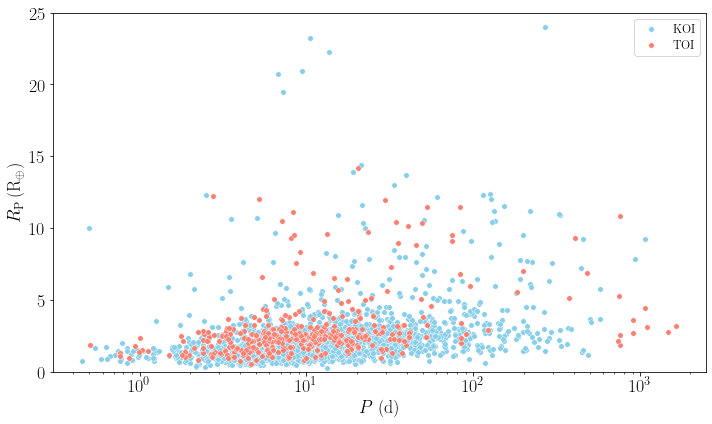

In [229]:
# plot radius vs period for multi-planet systems in the same figure
plt.figure(figsize=(10, 6))
sns.scatterplot(data=koi_pc_multi, x='koi_period', y='koi_prad', color='skyblue', label='KOI', s=30)
sns.scatterplot(data=toi_pc_multi, x='pl_orbper', y='pl_rade', color='salmon', label='TOI', s=30)
plt.xscale('log')
plt.xlabel(r'$P$ (d)', fontsize=18)
plt.ylabel(r'$R_{\mathrm P}\,(\mathrm{R_\oplus})$', fontsize=18)
plt.ylim([0, 25])
plt.legend(title='', loc='upper right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.savefig('figures/toi_koi_multi_planet_systems_radius_vs_period.pdf')
plt.show()

In [232]:
((toi_pc_multi['pl_rade'] > 10) & (toi_pc_multi['pl_orbper'] < 12)).sum() / ((toi_pc_dist_gmag['pl_rade'] > 10) & (toi_pc_dist_gmag['pl_orbper'] < 12)).sum()

0.0032599837000814994

In [239]:
toi_pc_multi[((toi_pc_multi['tfopwg_disp']=='PC') | (toi_pc_multi['tfopwg_disp']=='APC'))].drop_duplicates(subset=['tid'])
print(f"Number of new TOI multi-planet systems: {len(toi_pc_multi[((toi_pc_multi['tfopwg_disp']=='PC') | (toi_pc_multi['tfopwg_disp']=='APC'))].drop_duplicates(subset=['tid']))}")

Number of new TOI multi-planet systems: 103
